In [227]:
from __future__ import print_function, division

import os

from PIL import Image
from skimage import io,transform
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

# To access Google Drive:
from google.colab import drive
drive.mount("/content/gdrive")

import time
import copy
from tqdm import tqdm


import cv2

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("NumPy Version: ",np.__version__)
print("OpenCV Version: ",cv2.__version__)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
NumPy Version:  1.19.5
OpenCV Version:  4.1.2


In [228]:
class FacialKeypoint(Dataset):

  def __init__(self,root_dir,data_path,transform = None):
    self.root_dir = root_dir
    self.data_path = data_path
    self.transform = transform

    self.img_keypoints = pd.read_csv(os.path.join(self.root_dir,self.data_path))

  def __len__(self):
    return self.img_keypoints.__len__()

  def __getitem__(self,index):

    img = io.imread(os.path.join(self.root_dir,
                                  self.img_keypoints.iloc[index,0])
                                  )
    

    keypoints = np.array([self.img_keypoints.iloc[index,1:]]).astype('float').reshape(-1,2)

    if self.transform is not None:
      img,keypoints = self.transform((img,keypoints))

    return (img,keypoints)

In [229]:
class Resize(object):
  def __init__(self,size):
    assert isinstance(size,(int,tuple))
    self.size = size

  def __call__(self,data):
    img , keypoint = data
    
    h, w = img.shape[:2]
    if isinstance(self.size, int):
        if h > w:
            new_h, new_w = self.size * h / w, self.size
        else:
            new_h, new_w = self.size, self.size * w / h
    else:
        new_h, new_w = self.size

    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(img, (new_h, new_w))
    
    keypoint *= [new_w / w, new_h / h]
    return img, keypoint   

class RandomCrop(object):
  def __init__(self,size):
    assert isinstance(size, (int, tuple))
    if isinstance(size, int):
        self.size = (size, size)
    else:
        assert len(size) == 2
        self.size = size

  def __call__(self,data):
    img,keypoint = data
    
    h, w = img.shape[:2]
    new_h, new_w = self.size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    img = img[top: top + new_h,
                  left: left + new_w]

    keypoint -= [left, top]

    return img,keypoint


class ToTensor(object):
  def __call__(self,data):
    img,keypoint = data
    in_tsfm = T.ToTensor()
    return in_tsfm(img).type(torch.FloatTensor),torch.from_numpy(keypoint)
  
class RandomGrayScale(object):
  def __call__(self,data):
    img,keypoint = data
    in_tsfm = T.RandomGrayscale()
    return in_tsfm(img),keypoint

class Normalize(object):
  def __call__(self,data):
    img,keypoint = data
    return img, (keypoint - 100)/50.0


class ColorJitter(object):
  def __call__(self,data):
    img,keypoint = data
    in_tsfm = T.ColorJitter(brightness=0.9, contrast=0.9, saturation=0, hue=0)
    return in_tsfm(img),keypoint


class GaussianBlur(object):
  def __call__(self,data):
    img,keypoint = data
    in_tsfm = T.GaussianBlur(3, sigma=(0.1, 2.0))
    return in_tsfm(img),keypoint  


In [230]:
root_dir = '/content/gdrive/My Drive/Data/Colab/faces'

FacialKeypointData = FacialKeypoint(root_dir  = root_dir,
                                    data_path = 'face_landmarks.csv',
                                    transform = T.Compose([
                                                Resize(225),
                                                RandomCrop(224),
                                                ToTensor(),
                                                ColorJitter(), 
                                                RandomGrayScale(),
                                                GaussianBlur(),
                                                Normalize() 
                                                
                                                ]))    

testFacialKeypointData =  FacialKeypoint(root_dir  = data_dir,
                                    data_path = 'face_landmarks.csv',
                                    transform = T.Compose([
                                                Resize((224,224)),                                              
                                                ToTensor(),                                                
                                                Normalize()
                                                  ])) 

In [231]:
def timeit(Func):
    def _timeStamp(*args, **kwargs):
        since = time.time()
        result = Func(*args, **kwargs)
        time_elapsed = time.time() - since

        if time_elapsed > 60:
           print('Time Consumed : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
        else:        
          print('Time Consumed : ' , round((time_elapsed),4) , 's')
        return result
    return _timeStamp

In [232]:
def visualize_sample(sample):
    """Show image with facial keypoints"""
    image,keypoint = sample
    plt.figure()

    if type(image).__name__ == 'Tensor' and \
       type(keypoint).__name__ == 'Tensor':
      plt.imshow(image.permute(1,2,0).cpu())
      keypoint = keypoint.cpu().detach().numpy()
      plt.scatter(keypoint[:, 0], keypoint[:, 1], s=10, marker='.', c='r')
    else:
      plt.imshow(image)
      plt.scatter(keypoint[:, 0], keypoint[:, 1], s=10, marker='.', c='r')
    
    plt.pause(0.0001)  
    plt.show()

In [233]:
# We will be working with GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_GPU = torch.cuda.device_count()
batch_size = 4

data_transformed = {'train' : FacialKeypointData,
                    'val' : testFacialKeypointData}

dataloaders = {x : DataLoader(data_transformed[x], batch_size = batch_size,
                              shuffle = True,
                              num_workers = 4 * num_GPU,
                              pin_memory = True,
                              drop_last=True)
              for x in ['train','val']}

In [234]:
class PreTrainedModels(object):
  """ In this class, state of the art CNN models are placed.
      All models are trained on ImageNet dataset and 1000 classes.
      However, all necessary changes are done in terms of shapes of layer.
      Models : [resnet, alexnet, vgg, densenet]
      Args:         
        num_class (int): Number of classes in the dataset.
         
  """

  def __init__(self,num_classes):

    self.num_classes = num_classes    
    self.model = None
    
    
  def set_parameter_requires_grad(self,model,feature_extracting):
    """ İf feature extracking, we set pre-trained parameters's 
        requires_grad = False, since no need to calculate the gra
        dients of the non-updatable parameters.

        Args :
          model (callable)             : PyTorch's torchvision's CNN models
          feature_extracting (Boolean) : True if feature extracking and False if fine-tuning
    """

    if feature_extracting:
      for param in model.parameters():
        param.requires_grad = False


  def ResNet(self,feature_extract = True):
    """ ResNet 152    
    Args:
      feature_extracting (Boolean) : True if feature extracking and False if fine-tuning

    Returns a tuple of :
      ResNet 18 pretained model and it's expected input size
    
    """
    
    self.model = torchvision.models.resnet152(pretrained=True)
    self.set_parameter_requires_grad(self.model,feature_extract)
    in_ftrs = self.model.fc.in_features
    #modules = list(self.model.children())[:-1]      # delete the last fc layer.
    #self.model = nn.Sequential(*modules)
    self.model.fc = nn.Linear(in_ftrs,self.num_classes)
    
    return self.model

  def VGG(self,feature_extract = True):
    """ VGG11_bn
        Args:
          feature_extracting (Boolean) : True if feature extracking and False if fine-tuning

        Returns a tuple of :
          VGG11_bn pretained model and it's expected input size
    """
    self.model = torchvision.models.vgg19_bn(pretrained=True)
    self.set_parameter_requires_grad(self.model,feature_extract)
    in_ftrs = self.model.classifier[6].in_features    
    self.model.classifier[6] = nn.Linear(in_ftrs,self.num_classes)
    return self.model


NUM_CLASS = 68 * 2
ResNet = PreTrainedModels(NUM_CLASS).ResNet(feature_extract = True)

In [235]:
class Model(nn.Module):
  def __init__(self,model = None):
    super(Model,self).__init__()
    if model is not None:
      self.model = model    
    else:
      self.model = nn.Sequential(
          self.conv_block(3,32,0.1),
          self.conv_block(32,64,0.15),
          self.conv_block(64,128,0.2),
          self.conv_block(128,256,0.25),
          self.conv_block(256,512,0.3),
          self.conv_block(512,1024,0.35),
          nn.Flatten(),
          self.linear_block(1024,512,0.4),
          self.linear_block(512,256,0.4),
          nn.Linear(256,136)
      )     
      
  def forward(self,img):    
    return self.model(img)  

  @staticmethod
  def conv_block(in_channel,out_channel,p):
    return nn.Sequential(
      nn.Conv2d(in_channel, out_channel, 3),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout2d(p)
      )
    
  @staticmethod
  def linear_block(in_ftrs,out_ftrs,p):
    return nn.Sequential(
        nn.Linear(in_ftrs,out_ftrs),
        nn.BatchNorm1d(num_features=out_ftrs),
        nn.ReLU(),
        nn.Dropout(p)
    )
    
net = Model().to(device)

In [236]:
print(net)

Model(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.15, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.2, inplace=Fal

In [237]:
summary(net, (3, 224, 224),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 32, 222, 222]             896
       BatchNorm2d-2          [4, 32, 222, 222]              64
              ReLU-3          [4, 32, 222, 222]               0
         MaxPool2d-4          [4, 32, 111, 111]               0
         Dropout2d-5          [4, 32, 111, 111]               0
            Conv2d-6          [4, 64, 109, 109]          18,496
       BatchNorm2d-7          [4, 64, 109, 109]             128
              ReLU-8          [4, 64, 109, 109]               0
         MaxPool2d-9            [4, 64, 54, 54]               0
        Dropout2d-10            [4, 64, 54, 54]               0
           Conv2d-11           [4, 128, 52, 52]          73,856
      BatchNorm2d-12           [4, 128, 52, 52]             256
             ReLU-13           [4, 128, 52, 52]               0
        MaxPool2d-14           [4, 128,

In [238]:
print('Traniable parameter of the model: ' , sum(param.numel() for param in net.parameters() if param.requires_grad == True))

Traniable parameter of the model:  6984840


In [239]:
criterion = nn.SmoothL1Loss().to(device)

#criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(),lr = 1e-3)

In [240]:
# For pretrained models, set feature_extract = True so that see which parameters should be updated
feature_extract = True

# Just check the uptadable parameters:
if feature_extract:  
  for name,param in net.named_parameters():
    if param.requires_grad == True:      
      print("\t", name)
else:
  for name,param in net.named_parameters():
    if param.requires_grad == True:
      print("\t", name)

	 model.0.0.weight
	 model.0.0.bias
	 model.0.1.weight
	 model.0.1.bias
	 model.1.0.weight
	 model.1.0.bias
	 model.1.1.weight
	 model.1.1.bias
	 model.2.0.weight
	 model.2.0.bias
	 model.2.1.weight
	 model.2.1.bias
	 model.3.0.weight
	 model.3.0.bias
	 model.3.1.weight
	 model.3.1.bias
	 model.4.0.weight
	 model.4.0.bias
	 model.4.1.weight
	 model.4.1.bias
	 model.5.0.weight
	 model.5.0.bias
	 model.5.1.weight
	 model.5.1.bias
	 model.7.0.weight
	 model.7.0.bias
	 model.7.1.weight
	 model.7.1.bias
	 model.8.0.weight
	 model.8.0.bias
	 model.8.1.weight
	 model.8.1.bias
	 model.9.weight
	 model.9.bias


In [241]:
# Vanilla schedulers:
scheduler_LambdaLR = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.999 ** epoch)

# Monitoring val loss:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',
                                                 patience = 5 , verbose = True,
                                                 min_lr = 1e-5, factor = 5e-1)

In [242]:
@timeit
def train(net,dataloader,optimizer,criterion,
          num_epoch = 50, path_name = 'facialDetector',
          schedulers_bool = True, scheduler_LambdaLR = None,
          scheduler = scheduler, checkpoint = False):
      
  PATH = 'models'

  # To keep track history:
  train_loss_history = []
  best_loss = float('inf')
  
  best_model_wts = copy.deepcopy(net.state_dict())

  if checkpoint:
    if os.path.exists(os.path.join(root_dir,PATH,path_name) + '.pth'):
      print('Wearing weights ...')
      checkpoint = torch.load(os.path.join(root_dir,PATH,path_name) + '.pth')
      net.load_state_dict(checkpoint) 
      net.to(device)
  
  

  for epoch in range(num_epoch): 
      
      running_loss = 0.0
      for imgs, keypoints in dataloader:
        
          imgs = imgs.to(device)       

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(imgs)

          loss = criterion(outputs, keypoints.view(keypoints.size(0),-1).type(torch.FloatTensor).to(device))
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          

      epoch_loss = running_loss / len(dataloader.dataset)
      print(f'Epoch : [{epoch + 1}/{num_epoch}] Loss: {epoch_loss}')
      
      if scheduler:
        if scheduler_LambdaLR is not None:
          scheduler_LambdaLR.step()     
         
        scheduler.step(epoch_loss)  
        
      train_loss_history.append(epoch_loss)

      if  epoch_loss < best_loss:
        best_loss = epoch_loss                
        best_model_wts = copy.deepcopy(net.state_dict())
      
           
  if not os.path.exists(os.path.join(root_dir,PATH)):
    os.mkdir(os.path.join(root_dir,PATH))

  torch.save(best_model_wts,
            os.path.join(root_dir,PATH,path_name) + ".pth")   

  print('Model is Saved as a' , path_name , 'in the folder ' , str(os.path.join(root_dir,PATH))) 
 
  return {'model'    : net, 
          'History'  : train_loss_history,
          'best_wts' : best_model_wts} 

In [ ]:
outs = train(net,dataloaders['train'],
             optimizer, criterion,
             num_epoch = 500, scheduler_LambdaLR = scheduler_LambdaLR,
             checkpoint = False , path_name = 'FacialDetector')

In [ ]:
plt.figure()
plt.plot(outs['History'])
plt.xlabel('# of Epoch')
plt.ylabel('Training Loss')
plt.title('Learning curve over epochs')

In [280]:
@timeit
def test_batch(outs = None, net = net, batch_index = np.random.randint(batch_size), 
               net_path = 'FacialDetector', dataloaders = dataloaders, 
               checkpoint = False, best_wts = False):


    if checkpoint:
      if os.path.exists(os.path.join(root_dir,'models',net_path) +  '.pth'):
        print('Saved Model loading...')
        net.load_state_dict(torch.load(os.path.join(root_dir,'models',net_path) +  '.pth'))
      
    else:
      if outs is not None:
        net = outs['model']

        if best_wts: 
          net.load_state_dict(outs['best_wts'])

      else:
        raise Exception("No model found!")

    with torch.no_grad():
      net.eval()
      net = net.to(device)

      image,keypoint = next(iter(dataloaders['val']))
      outputs = net(image.to(device))
      
      assert (outputs.view(4,68,2).size() == keypoint.size()) , "Outputs and labels size does not match"

      outputs = outputs.cpu().detach().numpy()
      outputs = outputs * 50.0 + 100
      outputs = np.reshape(outputs, (4,68, -1))

    plt.figure()
    plt.imshow(image[batch_index].permute(1,2,0), cmap='gray')
    plt.scatter(outputs[batch_index][:, 0], outputs[batch_index][:, 1], s=40, marker='.', c='m')

Saved Model loading...
Time Consumed :  1.0393 s


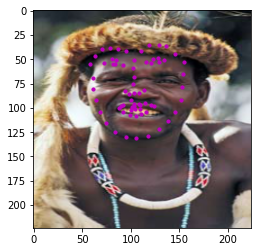

In [284]:
test_batch(batch_index = 3,checkpoint = True)

In [296]:
@timeit
def detect_landmarks(img_path,root_dir = root_dir,net = net, show_pic = True):
  img = cv2.imread(os.path.join(root_dir,img_path))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  if show_pic:
    plt.figure()
    plt.imshow(img)
    plt.title('Original Image')

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

  faces = face_cascade.detectMultiScale(img,1.2,2)
  detected_img= img.copy()

  for x,y,w,h in faces:
    cv2.rectangle(detected_img,(x,y),(x+w,y+h),(255,0,0),3)
  
  plt.figure()
  plt.imshow(detected_img)
  plt.title('Faces Detected')
    
  image = img.copy()
  transformation = T.Compose([T.Resize(224),
                              T.ToTensor()])
  
  for x,y,w,h in faces:
    roi = image[y: y+ int(1.5 * h) , x - int(0.4 * w):x + int(1.1 * w)]  
    roi_transformed = transformation(Image.fromarray(roi)).type(torch.FloatTensor).to(device)
    outputs = net(Variable(roi_transformed.unsqueeze(0)))
    
    outputs = outputs.cpu().detach().numpy()
    outputs = outputs * 50.0 + 100
    outputs = np.reshape(outputs, (68, -1))
    
    plt.figure()
    plt.imshow(roi, cmap='gray')
    plt.scatter(outputs[:, 0], outputs[:, 1], s=40, marker='.', c='m')
    plt.title('Landmarks Detected Image')

Time Consumed :  0.6608 s


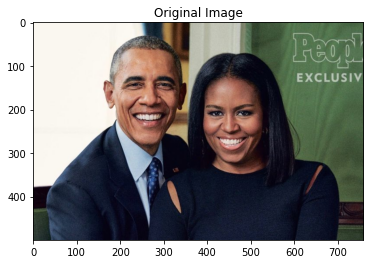

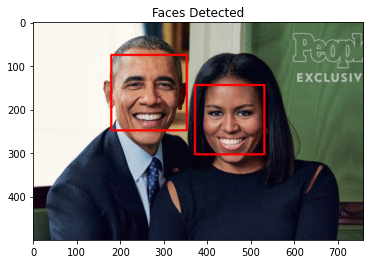

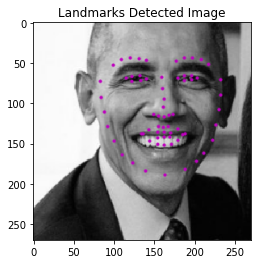

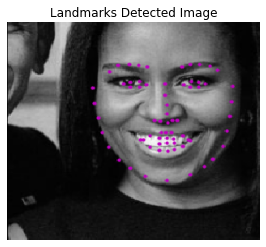

In [292]:
obama =  'obamas.jpg'
me = 'me.jpeg'

detect_landmarks(obama)